In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import h5py as h5
import numpy as np
import os

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use("./paper.mplstyle")

from scipy.interpolate import interp1d
from scipy.optimize import ridder

# Set up ASTERIA
import sys
ASTERIA_PATH = "/Users/jlazar/research/ASTERIA"
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"
sys.path.append(f"{ASTERIA_PATH}/python/")

sys.path.append("../")

from sne_bsm import units, parameterized_flux_from_h5, deserialize

In [56]:
# Where tabulated SM fluxes are stored. See `prepare_h5_file.ipynb` for the expected format
TABULATED_SM_FILE = "data/sm_flux.h5"
# Where to store the parameterized SM flux for later use
SERIALIZED_SM_FILE = "./data/serialized_sm_flux.h5"
# Where tabulated BSM fluxes are stored. See `prepare_h5_file.ipynb` for the expected format
TABULATED_BSM_FILE = "data/majoran_fluxes.h5"
# TABULATED_BSM_FILE = "data/magnetic_moment_fluxes.h5"
# Where to store the parameterized models for later use
SERIALIZED_BSM_FILE = "./data/serialized_majoran_fluxes.h5"
# SERIALIZED_BSM_FILE = "./data/serialized_magnetic_moment_fluxes.h5"
# Where to save the computed sensitivities
RESULTS_FILE = "./data/new_results.h5"
# What to call the results in the ``RESULTS
RESULTS_NAME = "majoron_sensitivities"

# First, we will parameterize the SM flux

In [58]:
if os.path.exists(SERIALIZED_SM_FILE):
    with h5.File(SERIALIZED_SM_FILE, "r") as h5f:
        done_keys = list(h5f.keys())

with h5.File(TABULATED_SM_FILE, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=1, track=False)
        pflux.serialize(SERIALIZED_SM_FILE, key)

100%|██████████| 1/1 [00:00<00:00, 1779.51it/s]


# Next, we will do the same for the BSM fluxes.

Depending on how many fluxes you are considering, this could take awhile...
The `thin` parameter can be increased to make this go faster, but will only use one out of every `thin` time point.

In [59]:
thin = 10

done_keys = []
if os.path.exists(SERIALIZED_BSM_FILE):
    with h5.File(SERIALIZED_BSM_FILE) as h5f:
        done_keys = list(h5f.keys())

with h5.File(TABULATED_BSM_FILE, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=thin, track=False)
        pflux.serialize(SERIALIZED_BSM_FILE, key)

100%|██████████| 63/63 [00:00<00:00, 3451.65it/s]


# Define the likelihood and such

In [60]:
TMAX = 100 * units["second"]
TMIN = 1e-2 * units["second"]
TMINS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)
DTS = np.linspace(0.001, 5, 401) * units["second"]

def find_significance_matrix(sig_hits, sm_hits, bg_hits, times, tmins=TMINS, dts=DTS):
    significance = np.full(tmins.shape + dts.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, dt in enumerate(dts):
            m = np.logical_and(tmin < times, times < tmin+dt)
            if not m.sum():
                continue
            significance[idx, jdx] = likelihood(sig_hits[m], sm_hits[m], bg_hits[m])
    return significance, tmins, dts

def likelihood(sig_hits, sm_hits, bg_hits):
    n_obs = (bg_hits + sm_hits).sum()
    n_exp = (sig_hits + bg_hits + sm_hits).sum()
    llh = 2 * (n_exp - n_obs)
    if n_obs > 0:
        llh += 2 * n_obs * np.log(n_obs / n_exp)
    return llh

# Now we can compute the significance

In [75]:
# with h5.File("data/serialized_sm_flux.h5", "r") as h5f:
#     sm_flux = deserialize(h5f["sm_flux_0"])
    
# sm_t, sm_hits = sm_flux.get_hits(
#     tmax=100 * units["second"],
#     model_file="magnetic_moment.txt"
# )
out = {}

with h5.File(SERIALIZED_BSM_FILE, "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", "").replace("d", "."))
        
        # if mass!=100:
        #     continue
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}".replace("d", "."))
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        out[mass].append((coupling, significance[m].max()))

100%|██████████| 63/63 [1:48:59<00:00, 103.80s/it]


# Compute the sensitivity by interpolating in log-space on the points in parameter space from the last step.

In [76]:
sensitivities = []

for k, v in out.items():
    v = sorted(v)
    
    couplings = np.power(10, [x[0] for x in v])
    significnces = [x[1] for x in v]
    
    try:
        interp = interp1d(np.log(couplings), np.log(significnces))
        f = lambda lc: np.exp(interp(lc)) - 3.841
        res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
        sens = np.exp(res)
        sensitivities.append((k, sens))
    except ValueError:
        pass
    
sensitivities = sorted(sensitivities)

In [77]:
masses = np.array([x[0] for x in sensitivities])
couplings = np.array([x[1] for x in sensitivities])

if not os.path.exists(RESULTS_FILE):
    with h5.File(RESULTS_FILE, "w") as _:
        pass

with h5.File(RESULTS_FILE, "r+") as h5f:
    if RESULTS_NAME in h5f.keys():
        del h5f[RESULTS_NAME]
    h5f.create_group(RESULTS_NAME)
    h5f[RESULTS_NAME].create_dataset("masses", data=masses)
    h5f[RESULTS_NAME].create_dataset("couplings", data=couplings)

# Now let's do it all again for Gen2

We will estimate this by scaling the number of hits seen in the Gen1 case by the "effective photoncathode area."
We define this to be:
$$
\sum_{i\in\mathrm{modules}} \varepsilon_{i} \times A_{i},
$$
where $\varepsilon_{i}$ and $A_{i}$ are the quantum efficiency (QE) and photocathode area for a given OM.
IceCube has 5,160 optical modules.
4,680 of these use Hamamatsu R7081-02 with a 10-inch photo cathode diameter and a QE of 0.25, while the remaining 480 of these use Hamamatsu R7081-02MOD with a 10-inch photocathode diameter and a QE of 0.34.
See [the IceCube instrumentation on online systems paper](https://arxiv.org/abs/1612.05093) for further details.
IceCube Gen2 will contain 9,600 new optical modules, each with 24 3-inch PMTs with quantum efficiency equal to the high-QE Gen1 OMs.
See [this paper](https://arxiv.org/abs/2008.04323) for details

In [79]:
ep1 = 0.25
ep2 = 0.34

gen1_area = np.pi * (10 / 2)**2
gen2_area = 24 * np.pi * (3 / 2)**2

gen1_eff_pc_area = 4680 * gen1_area * ep1 + 480 * gen1_area * ep2
gen2_eff_pc_area = gen1_eff_pc_area + 9600 * gen2_area * ep2

r = gen2_eff_pc_area / gen1_eff_pc_area

In [83]:
with h5.File(SERIALIZED_SM_FILE, "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="magnetic_moment.txt"
)

sm_hits *= r

out = {}

with h5.File(SERIALIZED_BSM_FILE, "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", "").replace("d", "."))

        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}".replace("d", "."))
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bsm_hits *= r
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits *= r
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        out[mass].append((coupling, significance[m].max()))

100%|██████████| 63/63 [1:48:17<00:00, 103.14s/it]


In [84]:
sensitivities = []

for k, v in out.items():
    v = sorted(v)
    
    couplings = np.power(10, [x[0] for x in v])
    significnces = [x[1] for x in v]
    
    try:
        interp = interp1d(np.log(couplings), np.log(significnces))
        f = lambda lc: np.exp(interp(lc)) - 3.841
        res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
        sens = np.exp(res)
        sensitivities.append((k, sens))
    except ValueError:
        pass

In [85]:
sensitivities  = sorted(sensitivities)
masses = np.array([x[0] for x in sensitivities])
couplings = np.array([x[1] for x in sensitivities])

if not os.path.exists(RESULTS_FILE):
    with h5.File(RESULTS_FILE, "w") as _:
        pass

with h5.File(RESULTS_FILE, "r+") as h5f:
    if f"{RESULTS_NAME}_gen2" in h5f.keys():
        del h5f[f"{RESULTS_NAME}_gen2"]
    h5f.create_group(f"{RESULTS_NAME}_gen2")
    h5f[f"{RESULTS_NAME}_gen2"].create_dataset("masses", data=masses)
    h5f[f"{RESULTS_NAME}_gen2"].create_dataset("couplings", data=couplings)

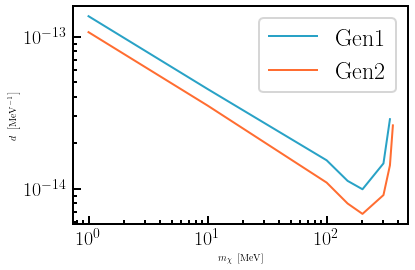

In [89]:
fig, ax = plt.subplots()

for suffix, label in zip(["", "_gen2"], ["Gen1", "Gen2"]):
    with h5.File(RESULTS_FILE) as h5f:
        gp = h5f[f"{RESULTS_NAME}{suffix}"]
        ax.plot(gp["masses"][:], gp["couplings"][:], label=label)

ax.loglog()
ax.legend()
ax.set_xlabel(r"$m_{\chi}~\left[\mathrm{MeV}\right]$")
ax.set_ylabel(r"$d~\left[\mathrm{MeV}^{-1}\right]$")
# Uncomment if doing majoran case
# ax.set_ylabel(r"$g_{\phi}$")
plt.show()